# Multi-Attention (MAT)

In [1]:
# Import Pustaka Standar dan PyTorch
import os
import re
import math
import collections
from functools import partial
import logging
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo
import numpy as np
import kornia # Diperlukan untuk AGDA

# Pengaturan logging dasar
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print(f"PyTorch version: {torch.__version__}")
print(f"Kornia version: {kornia.__version__}")

PyTorch version: 2.6.0+cu124
Kornia version: 0.8.1


# Fungsi Utilitas dan Preprocessing

## Parameter Global dan Utilitas Dasar

In [2]:
# Parameter Global dan Utilitas Dasar
# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

## Utilitas Konvolusi dengan Padding

In [3]:
# Utilitas Konvolusi dengan Padding
def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""
    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x

## Utilitas untuk Parameter dan Konfigurasi Backbone

In [4]:
#Utilitas untuk Parameter dan Konfigurasi Backbone
class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """
    @staticmethod
    def _decode_block_string(block_string):
        assert isinstance(block_string, str)
        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.stride[0], block.stride[0]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if hasattr(block, 'se_ratio') and block.se_ratio is not None and 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if hasattr(block, 'id_skip') and block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings

url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c321c.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}

url_map_advprop = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',
}

def load_pretrained_weights(model, model_name, load_fc=True, advprop=False):
    """ Loads pretrained weights, and optionally pinpoints error on incorrect architecture. """
    urls = url_map_advprop if advprop else url_map
    if model_name not in urls:
        raise ValueError(f'model_name {model_name} not in pretrained weights')

    state_dict = model_zoo.load_url(urls[model_name], progress=True, map_location='cpu')

    if not load_fc:
        # Hapus bobot dari layer klasifikasi (fully connected) jika num_classes berbeda
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')

    # Muat state_dict ke model
    ret = model.load_state_dict(state_dict, strict=False)
    
    # Periksa apakah ada layer yang tidak cocok
    assert set(ret.missing_keys) == set(), f'Missing keys: {ret.missing_keys}'
    logging.info(f"Loaded pretrained weights for {model_name}")

# >> LETAKKAN SEBELUM `class EfficientNet(nn.Module):` <<

def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]

def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """
    blocks_args_str = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args_str)

    global_params = GlobalParams(
        batch_norm_momentum=0.99, batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate, drop_connect_rate=drop_connect_rate,
        num_classes=num_classes, width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient, depth_divisor=8,
        min_depth=None, image_size=image_size,
    )
    return blocks_args, global_params

def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError(f'model name is not pre-defined: {model_name}')
    if override_params:
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


# Arsitektur Backbone

## Arsitektur EfficientNet

### Blok Penyusun EfficientNet

In [5]:
# Blok Penyusun EfficientNet
class MBConvBlock(nn.Module):
    """ Mobile Inverted Residual Bottleneck Block """
    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip

        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        inp = self._block_args.input_filters
        oup = self._block_args.input_filters * self._block_args.expand_ratio
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == [1] and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs
        return x

    def set_swish(self, memory_efficient=True):
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()

### Kelas Utama EfficientNet

In [6]:
class EfficientNet(nn.Module):
    """ An EfficientNet model. """
    def __init__(self, blocks_args=None, global_params=None, escape=''):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self.escape = escape
        self._global_params = global_params
        self._blocks_args = blocks_args
        
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        in_channels = 3
        out_channels = round_filters(32, self._global_params)
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        self._blocks = nn.ModuleList([])
        self.stage_map = []
        stage_count = 0
        last_block_args = None
        for block_args in self._blocks_args:
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )
            stage_count += 1
            self.stage_map += [''] * (block_args.num_repeat - 1)
            self.stage_map.append(f'b{stage_count}')
            
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=[1])
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))
            last_block_args = block_args

        in_channels_head = last_block_args.output_filters
        out_channels_head = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels_head, out_channels_head, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels_head, momentum=bn_mom, eps=bn_eps)

        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels_head, self._global_params.num_classes)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_features(self, inputs, layers):
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        layers['b0'] = x
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            stage = self.stage_map[idx]
            if stage:     
                layers[stage] = x
                if stage == self.escape:
                    return None
        x = self._swish(self._bn1(self._conv_head(x)))
        return x

    def forward(self, x):
        bs = x.size(0)
        layers = {}
        x = self.extract_features(x, layers)
        if x is None:
            return layers 
        
        layers['final_conv'] = x
        
        x_pool = self._avg_pooling(x)
        x_pool = x_pool.view(bs, -1)
        x_pool = self._dropout(x_pool)
        x_logits = self._fc(x_pool)
        layers['logits'] = x_logits
        return layers

    @classmethod
    def from_name(cls, model_name, override_params=None, escape=''):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params, escape)

    @classmethod
    def from_pretrained(cls, model_name, advprop=False, num_classes=1000, in_channels=3, escape=''):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes}, escape=escape)
        try:
            load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000), advprop=advprop)
        except Exception as e:
            print(f"Could not load pretrained weights for {model_name}: {e}. Model will be initialized randomly.")

        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        valid_models = [f'efficientnet-b{i}' for i in range(9)] + ['efficientnet-l2']
        if model_name not in valid_models:
            raise ValueError(f'model_name should be one of: {", ".join(valid_models)}')

## Arsitektur Xception

In [7]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self, in_filters, out_filters, reps, strides=1, start_with_relu=True, grow_first=True):
        super(Block, self).__init__()
        if out_filters != in_filters or strides != 1:
            self.skip = nn.Conv2d(in_filters, out_filters, 1, stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip = None

        rep = []
        filters = in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps - 1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters, out_filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            if rep:
                rep = rep[1:]
        else:
            if rep:
                rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))
        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)
        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp
        x = x + skip
        return x

### Kelas Utama Xception

In [8]:
class xception_model(nn.Module):
    """ Xception optimized for ImageNet. """
    def __init__(self, num_classes=1000, pretrained='imagenet', escape=''):
        super(xception_model, self).__init__()
        self.escape = escape
        self.num_classes = num_classes

        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.block1 = Block(64, 128, reps=2, strides=2, start_with_relu=False, grow_first=True)
        self.block2 = Block(128, 256, reps=2, strides=2, start_with_relu=True, grow_first=True)
        self.block3 = Block(256, 728, reps=2, strides=2, start_with_relu=True, grow_first=True)
        # Middle flow
        self.block4 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block5 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block6 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block7 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block8 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block9 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, strides=1, start_with_relu=True, grow_first=True)
        # Exit flow
        self.block12 = Block(728, 1024, reps=2, strides=2, start_with_relu=True, grow_first=False)
        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = SeparableConv2d(1536, 2048, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.last_linear = nn.Linear(2048, self.num_classes)
        
        # Urutan stage untuk forward pass dan feature extraction
        self.seq = [
            ('b0_conv1', [self.conv1, self.bn1, self.relu1]),
            ('b0_conv2', [self.conv2, self.bn2]),
            ('b1', [self.relu2, self.block1]),
            ('b2', [self.block2]), ('b3', [self.block3]), ('b4', [self.block4]),
            ('b5', [self.block5]), ('b6', [self.block6]), ('b7', [self.block7]),
            ('b8', [self.block8]), ('b9', [self.block9]), ('b10', [self.block10]),
            ('b11', [self.block11]), ('b12', [self.block12]),
            ('final_conv3', [self.conv3, self.bn3, self.relu3]),
            ('final_conv4', [self.conv4, self.bn4]),
            ('logits', [self.relu4, self.avgpool, lambda x: x.view(x.size(0), -1), self.last_linear])
        ]
        
        if pretrained == 'imagenet':
            self.load_imagenet_weights()
        elif pretrained and isinstance(pretrained, str):
            self.load_custom_weights(pretrained)
        else:
            print("Model weights are randomly initialized.")
            self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def load_imagenet_weights(self):
        try:
            state_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth')
            if self.num_classes != 1000:
                for key in ['last_linear.weight', 'last_linear.bias']:
                    if key in state_dict: del state_dict[key]
            self.load_state_dict(state_dict, strict=False)
            print(f"Loaded pretrained ImageNet weights for Xception (num_classes={self.num_classes}).")
            if self.num_classes != 1000: print("Classifier head (last_linear) re-initialized.")
        except Exception as e:
            print(f"Could not load pretrained ImageNet weights: {e}. Model weights are randomly initialized.")
            self._init_weights()

    def load_custom_weights(self, pretrained_path):
        try:
            ckpt = torch.load(pretrained_path, map_location='cpu')
            state_dict_to_load = ckpt.get('state_dict', ckpt)
            load_state(self, state_dict_to_load) # Menggunakan helper function
            print(f"Loaded pretrained weights from: {pretrained_path}")
        except Exception as e:
            print(f"Could not load weights from {pretrained_path}: {e}. Model weights are randomly initialized.")
            self._init_weights()
            
    def forward(self, x):
        layers = {}
        current_input = x
        for stage_name, stage_ops in self.seq:
            for op in stage_ops:
                current_input = op(current_input)
            layers[stage_name] = current_input
            if stage_name == self.escape:
                break
        return layers

## Architektur ConvNeXt

In [9]:
try:
    import timm
except ImportError:
    logging.error("`timm` tidak terinstal. Jalankan `pip install timm`.")
    timm = None

class ConvNeXtBackbone(nn.Module):
    """
    Wrapper untuk model ConvNeXt dari `timm` agar kompatibel dengan MAT.
    Model ini akan mengembalikan dictionary fitur dari layer-layer perantara.
    """
    def __init__(self, model_name='convnext_base.fb_in22k_ft_in1k', pretrained=True, num_classes=2):
        super().__init__()
        if timm is None:
            raise RuntimeError("Library `timm` diperlukan untuk ConvNeXtBackbone.")
            
        # Muat model ConvNeXt dengan `features_only=True`
        # Ini akan mengembalikan output dari setiap stage, bukan hanya logits
        self.net = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True,
            # `out_indices` menentukan output stage mana yang akan dikembalikan
            # (0,1,2,3) -> 4 stages, resolusi 1/4, 1/8, 1/16, 1/32
            out_indices=(0, 1, 2, 3) 
        )
        
        # Layer head untuk cabang global. Kita tambahkan secara manual.
        # Ambil jumlah fitur dari stage terakhir
        self.num_global_features = self.net.feature_info.channels()[-1]
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.num_global_features, num_classes)
        
        # Mapping nama generik ke nama stage timm
        # MAT akan menggunakan 's1', 's2', 's3', 's4'
        self.stage_map = {
            's1': 0, 's2': 1, 's3': 2, 's4': 3
        }

    def forward(self, x):
        # Dapatkan list fitur dari backbone
        # Outputnya adalah list of tensors, misal: [ (B, C1, H/4, W/4), (B, C2, H/8, W/8), ... ]
        features_list = self.net(x)
        
        # Buat dictionary `layers` yang diharapkan oleh MAT
        layers = {}
        for stage_name, idx in self.stage_map.items():
            layers[stage_name] = features_list[idx]

        # Tambahkan output untuk cabang global (mirip final_conv di EfficientNet)
        # Kita gunakan fitur dari stage terakhir
        global_features = features_list[-1]
        layers['final_conv'] = global_features
        
        # Hitung juga logits untuk kompatibilitas jika diperlukan
        pooled_features = self.global_pool(global_features).flatten(1)
        logits = self.fc(pooled_features)
        layers['logits'] = logits
        
        return layers

## Arsitektur ResNet-101

In [10]:
class ResNetBackbone(nn.Module):
    """
    Wrapper untuk model ResNet dari `timm` agar kompatibel dengan MAT.
    """
    def __init__(self, model_name='resnet101', pretrained=True, num_classes=2):
        super().__init__()
        if timm is None:
            raise RuntimeError("Library `timm` diperlukan untuk ResNetBackbone.")
            
        # Muat model ResNet dengan `features_only=True`
        self.net = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True,
            out_indices=(0, 1, 2, 3) # Stage 1, 2, 3, 4
        )
        
        # Layer head untuk cabang global (ditambahkan secara manual)
        self.num_global_features = self.net.feature_info.channels()[-1]
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.num_global_features, num_classes)
        
        # Mapping nama generik ke nama stage timm
        self.stage_map = {'s1': 0, 's2': 1, 's3': 2, 's4': 3}

    def forward(self, x):
        features_list = self.net(x)
        
        # Buat dictionary `layers` yang diharapkan oleh MAT
        layers = {stage_name: features_list[idx] for stage_name, idx in self.stage_map.items()}
        
        # Alias untuk cabang global dan logits
        global_features = features_list[-1]
        layers['final_conv'] = global_features
        layers['logits'] = self.fc(self.global_pool(global_features).flatten(1))
        
        return layers

# Arsitektur MAT

## Attention Map

In [11]:
class AttentionMap(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionMap, self).__init__()
        self.register_buffer('mask', torch.zeros([1, 1, 24, 24]))
        if out_channels > 0:
            self.mask[0, 0, 2:-2, 2:-2] = 1
        self.num_attentions = out_channels
        self.conv_extract = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) if out_channels > 0 else nn.Identity()

    def forward(self, x):
        if self.num_attentions == 0:
            return torch.ones([x.shape[0], 1, 1, 1], device=x.device)
        x = F.relu(self.bn1(self.conv_extract(x)), inplace=True)
        x = self.bn2(self.conv2(x))
        x = F.elu(x) + 1
        mask = self.mask.to(x.device)
        if x.shape[2:4] != mask.shape[2:4] and mask.sum() > 0:
            mask = F.interpolate(mask, (x.shape[2], x.shape[3]), mode='nearest')
        return x * mask

class AttentionPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features, attentions, norm=2):
        H, W = features.shape[-2:]
        attentions_resized = F.interpolate(attentions, size=(H, W), mode='bilinear', align_corners=True) if (attentions.shape[-2:] != (H,W)) else attentions
        
        if len(features.shape) == 4: # (B, C, H, W)
            feature_matrix = torch.einsum('bmhw,bchw->bmc', attentions_resized, features)
        elif len(features.shape) == 5: # (B, M, C_per_M, H, W)
            feature_matrix = torch.einsum('bmhw,bmchw->bmc', attentions_resized, features)
        else:
            raise ValueError(f"Unsupported feature shape: {features.shape}")

        if norm == 1:
            att_sum = torch.sum(attentions_resized, dim=(2,3), keepdim=True) + 1e-8
            normalized_attentions = attentions_resized / att_sum
            if len(features.shape) == 4:
                 feature_matrix = torch.einsum('bmhw,bchw->bmc', normalized_attentions, features)
            else:
                 feature_matrix = torch.einsum('bmhw,bmchw->bmc', normalized_attentions, features)
        elif norm == 2:
            feature_matrix = F.normalize(feature_matrix, p=2, dim=-1)
        elif norm == 3:
            w = torch.sum(attentions_resized, dim=(2, 3)).unsqueeze(-1) + 1e-8
            feature_matrix = feature_matrix / w
        return feature_matrix

class Texture_Enhance_v1(nn.Module):
    def __init__(self,num_features,num_attentions):
        super().__init__()
        self.output_features=num_features*4
        self.output_features_d=num_features
        self.conv0=nn.Conv2d(num_features,num_features,1)
        self.bn0 = nn.BatchNorm2d(num_features)
        self.conv1=nn.Conv2d(num_features,num_features,3,padding=1)
        self.bn1=nn.BatchNorm2d(num_features)
        self.conv2=nn.Conv2d(num_features*2,num_features,3,padding=1)
        self.bn2=nn.BatchNorm2d(num_features)
        self.conv3=nn.Conv2d(num_features*3,num_features,3,padding=1)
        self.bn3=nn.BatchNorm2d(num_features)
        self.conv_last=nn.Conv2d(num_features*4,num_features*4,1)
        self.bn_last=nn.BatchNorm2d(num_features*4)

    def forward(self,feature_maps,attention_maps=(1,1)):
        B,N,H,W=feature_maps.shape
        att_size=(int(H*attention_maps[0]),int(W*attention_maps[1])) if isinstance(attention_maps,tuple) else (attention_maps.shape[2],attention_maps.shape[3])
        feature_maps_d=F.adaptive_avg_pool2d(feature_maps,att_size)
        feature_maps_hp = feature_maps - F.interpolate(feature_maps_d,(H,W),mode='bilinear', align_corners=True) if (H>att_size[0] or W>att_size[1]) else feature_maps

        fm0 = F.relu(self.bn0(self.conv0(feature_maps_hp)), inplace=True)
        fm1 = F.relu(self.bn1(self.conv1(fm0)), inplace=True)
        fm1_ = torch.cat([fm0,fm1],dim=1)
        fm2 = F.relu(self.bn2(self.conv2(fm1_)), inplace=True)
        fm2_ = torch.cat([fm1_,fm2],dim=1)
        fm3 = F.relu(self.bn3(self.conv3(fm2_)), inplace=True)
        fm3_ = torch.cat([fm2_,fm3],dim=1)
        out = F.relu(self.bn_last(self.conv_last(fm3_)), inplace=True)
        return out, feature_maps_d

class Texture_Enhance_v2(nn.Module):
    def __init__(self, num_features, num_attentions):
        super().__init__()
        self.N_feat_per_map = num_features
        self.M = num_attentions
        self.output_features = self.N_feat_per_map
        self.output_features_d = self.N_feat_per_map
        MN = self.M * self.N_feat_per_map

        self.conv_extract = nn.Conv2d(num_features, self.N_feat_per_map, 3, padding=1)
        self.bn_extract = nn.BatchNorm2d(self.N_feat_per_map)
        self.conv0 = nn.Conv2d(MN, MN, 5, padding=2, groups=self.M)
        self.bn0 = nn.BatchNorm2d(MN)
        self.conv1 = nn.Conv2d(MN, MN, 3, padding=1, groups=self.M)
        self.bn1 = nn.BatchNorm2d(MN)
        self.conv2 = nn.Conv2d(MN*2, MN, 3, padding=1, groups=self.M)
        self.bn2 = nn.BatchNorm2d(MN)
        self.conv3 = nn.Conv2d(MN*3, MN, 3, padding=1, groups=self.M)
        self.bn3 = nn.BatchNorm2d(MN)
        self.bn4 = nn.BatchNorm2d(MN*4)
        self.conv_last = nn.Conv2d(MN*4, MN, 1, groups=self.M)
        self.bn_last = nn.BatchNorm2d(MN)

    def cat(self, a, b):
        B, C_a, H, W = a.shape
        a_r = a.view(B, self.M, -1, H, W)
        b_r = b.view(B, self.M, -1, H, W)
        return torch.cat([a_r, b_r], dim=2).view(B, -1, H, W)

    def forward(self, feature_maps_raw, attention_maps=(1,1)):
        B, N, H, W = feature_maps_raw.shape
        att_size = (int(H*attention_maps[0]), int(W*attention_maps[1])) if isinstance(attention_maps, tuple) else (attention_maps.shape[2], attention_maps.shape[3])

        base_feats = F.relu(self.bn_extract(self.conv_extract(feature_maps_raw)), inplace=True)
        feature_maps_d = F.adaptive_avg_pool2d(base_feats, att_size)
        feature_maps_hp = base_feats - F.interpolate(feature_maps_d, (H,W), mode='bilinear', align_corners=True) if (H>att_size[0] or W>att_size[1]) else base_feats

        if not isinstance(attention_maps, tuple):
            att_interp = torch.tanh(F.interpolate(attention_maps.detach(),(H,W),mode='bilinear',align_corners=True))
            current_fm = torch.cat([feature_maps_hp * att_interp[:, i:i+1] for i in range(self.M)], dim=1)
        else:
            current_fm = feature_maps_hp.repeat(1, self.M, 1, 1)

        fm0 = F.relu(self.bn0(self.conv0(current_fm)), inplace=True)
        fm1 = F.relu(self.bn1(self.conv1(fm0)), inplace=True)
        fm1_ = self.cat(fm0, fm1)
        fm2 = F.relu(self.bn2(self.conv2(fm1_)), inplace=True)
        fm2_ = self.cat(fm1_, fm2)
        fm3 = F.relu(self.bn3(self.conv3(fm2_)), inplace=True)
        fm3_ = self.cat(fm2_, fm3)
        
        final_conv_in = F.relu(self.bn4(fm3_), inplace=True)
        final_feats_grouped = F.relu(self.bn_last(self.conv_last(final_conv_in)), inplace=True)
        return final_feats_grouped.view(B, self.M, self.N_feat_per_map, H, W), feature_maps_d

## Pooling

In [12]:
class AttentionMap(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionMap, self).__init__()
        self.register_buffer('mask', torch.zeros([1, 1, 24, 24]))
        if out_channels > 0:
            self.mask[0, 0, 2:-2, 2:-2] = 1
        self.num_attentions = out_channels
        self.conv_extract = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) if out_channels > 0 else nn.Identity()

    def forward(self, x):
        if self.num_attentions == 0:
            return torch.ones([x.shape[0], 1, 1, 1], device=x.device)
        x = F.relu(self.bn1(self.conv_extract(x)), inplace=True)
        x = self.bn2(self.conv2(x))
        x = F.elu(x) + 1
        mask = self.mask.to(x.device)
        if x.shape[2:4] != mask.shape[2:4] and mask.sum() > 0:
            mask = F.interpolate(mask, (x.shape[2], x.shape[3]), mode='nearest')
        return x * mask

class AttentionPooling(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features, attentions, norm=2):
        H, W = features.shape[-2:]
        attentions_resized = F.interpolate(attentions, size=(H, W), mode='bilinear', align_corners=True) if (attentions.shape[-2:] != (H,W)) else attentions
        
        if len(features.shape) == 4: # (B, C, H, W)
            feature_matrix = torch.einsum('bmhw,bchw->bmc', attentions_resized, features)
        elif len(features.shape) == 5: # (B, M, C_per_M, H, W)
            feature_matrix = torch.einsum('bmhw,bmchw->bmc', attentions_resized, features)
        else:
            raise ValueError(f"Unsupported feature shape: {features.shape}")

        if norm == 1:
            att_sum = torch.sum(attentions_resized, dim=(2,3), keepdim=True) + 1e-8
            normalized_attentions = attentions_resized / att_sum
            if len(features.shape) == 4:
                 feature_matrix = torch.einsum('bmhw,bchw->bmc', normalized_attentions, features)
            else:
                 feature_matrix = torch.einsum('bmhw,bmchw->bmc', normalized_attentions, features)
        elif norm == 2:
            feature_matrix = F.normalize(feature_matrix, p=2, dim=-1)
        elif norm == 3:
            w = torch.sum(attentions_resized, dim=(2, 3)).unsqueeze(-1) + 1e-8
            feature_matrix = feature_matrix / w
        return feature_matrix

class Texture_Enhance_v1(nn.Module):
    def __init__(self,num_features,num_attentions):
        super().__init__()
        self.output_features=num_features*4
        self.output_features_d=num_features
        self.conv0=nn.Conv2d(num_features,num_features,1)
        self.bn0 = nn.BatchNorm2d(num_features)
        self.conv1=nn.Conv2d(num_features,num_features,3,padding=1)
        self.bn1=nn.BatchNorm2d(num_features)
        self.conv2=nn.Conv2d(num_features*2,num_features,3,padding=1)
        self.bn2=nn.BatchNorm2d(num_features)
        self.conv3=nn.Conv2d(num_features*3,num_features,3,padding=1)
        self.bn3=nn.BatchNorm2d(num_features)
        self.conv_last=nn.Conv2d(num_features*4,num_features*4,1)
        self.bn_last=nn.BatchNorm2d(num_features*4)

    def forward(self,feature_maps,attention_maps=(1,1)):
        B,N,H,W=feature_maps.shape
        att_size=(int(H*attention_maps[0]),int(W*attention_maps[1])) if isinstance(attention_maps,tuple) else (attention_maps.shape[2],attention_maps.shape[3])
        feature_maps_d=F.adaptive_avg_pool2d(feature_maps,att_size)
        feature_maps_hp = feature_maps - F.interpolate(feature_maps_d,(H,W),mode='bilinear', align_corners=True) if (H>att_size[0] or W>att_size[1]) else feature_maps

        fm0 = F.relu(self.bn0(self.conv0(feature_maps_hp)), inplace=True)
        fm1 = F.relu(self.bn1(self.conv1(fm0)), inplace=True)
        fm1_ = torch.cat([fm0,fm1],dim=1)
        fm2 = F.relu(self.bn2(self.conv2(fm1_)), inplace=True)
        fm2_ = torch.cat([fm1_,fm2],dim=1)
        fm3 = F.relu(self.bn3(self.conv3(fm2_)), inplace=True)
        fm3_ = torch.cat([fm2_,fm3],dim=1)
        out = F.relu(self.bn_last(self.conv_last(fm3_)), inplace=True)
        return out, feature_maps_d

class Texture_Enhance_v2(nn.Module):
    def __init__(self, num_features, num_attentions):
        super().__init__()
        self.N_feat_per_map = num_features
        self.M = num_attentions
        self.output_features = self.N_feat_per_map
        self.output_features_d = self.N_feat_per_map
        MN = self.M * self.N_feat_per_map

        self.conv_extract = nn.Conv2d(num_features, self.N_feat_per_map, 3, padding=1)
        self.bn_extract = nn.BatchNorm2d(self.N_feat_per_map)
        self.conv0 = nn.Conv2d(MN, MN, 5, padding=2, groups=self.M)
        self.bn0 = nn.BatchNorm2d(MN)
        self.conv1 = nn.Conv2d(MN, MN, 3, padding=1, groups=self.M)
        self.bn1 = nn.BatchNorm2d(MN)
        self.conv2 = nn.Conv2d(MN*2, MN, 3, padding=1, groups=self.M)
        self.bn2 = nn.BatchNorm2d(MN)
        self.conv3 = nn.Conv2d(MN*3, MN, 3, padding=1, groups=self.M)
        self.bn3 = nn.BatchNorm2d(MN)
        self.bn4 = nn.BatchNorm2d(MN*4)
        self.conv_last = nn.Conv2d(MN*4, MN, 1, groups=self.M)
        self.bn_last = nn.BatchNorm2d(MN)

    def cat(self, a, b):
        B, C_a, H, W = a.shape
        a_r = a.view(B, self.M, -1, H, W)
        b_r = b.view(B, self.M, -1, H, W)
        return torch.cat([a_r, b_r], dim=2).view(B, -1, H, W)

    def forward(self, feature_maps_raw, attention_maps=(1,1)):
        B, N, H, W = feature_maps_raw.shape
        att_size = (int(H*attention_maps[0]), int(W*attention_maps[1])) if isinstance(attention_maps, tuple) else (attention_maps.shape[2], attention_maps.shape[3])

        base_feats = F.relu(self.bn_extract(self.conv_extract(feature_maps_raw)), inplace=True)
        feature_maps_d = F.adaptive_avg_pool2d(base_feats, att_size)
        feature_maps_hp = base_feats - F.interpolate(feature_maps_d, (H,W), mode='bilinear', align_corners=True) if (H>att_size[0] or W>att_size[1]) else base_feats

        if not isinstance(attention_maps, tuple):
            att_interp = torch.tanh(F.interpolate(attention_maps.detach(),(H,W),mode='bilinear',align_corners=True))
            current_fm = torch.cat([feature_maps_hp * att_interp[:, i:i+1] for i in range(self.M)], dim=1)
        else:
            current_fm = feature_maps_hp.repeat(1, self.M, 1, 1)

        fm0 = F.relu(self.bn0(self.conv0(current_fm)), inplace=True)
        fm1 = F.relu(self.bn1(self.conv1(fm0)), inplace=True)
        fm1_ = self.cat(fm0, fm1)
        fm2 = F.relu(self.bn2(self.conv2(fm1_)), inplace=True)
        fm2_ = self.cat(fm1_, fm2)
        fm3 = F.relu(self.bn3(self.conv3(fm2_)), inplace=True)
        fm3_ = self.cat(fm2_, fm3)
        
        final_conv_in = F.relu(self.bn4(fm3_), inplace=True)
        final_feats_grouped = F.relu(self.bn_last(self.conv_last(final_conv_in)), inplace=True)
        return final_feats_grouped.view(B, self.M, self.N_feat_per_map, H, W), feature_maps_d

## Texture Enhancement

In [13]:
class Auxiliary_Loss_v1(nn.Module):
    def __init__(self, M, N_feat_per_map, C, alpha=0.05, margin=1, inner_margin=[0.01, 0.02]):
        super().__init__()
        self.M, self.N_feat_per_map, self.num_classes = M, N_feat_per_map, C
        self.register_buffer('feature_centers', torch.zeros(M, N_feat_per_map))
        self.register_buffer('alpha', torch.tensor(alpha))
        self.margin = margin
        self.atp = AttentionPooling()
        
        im = torch.tensor(inner_margin)
        if len(im) != C: im = im[0].repeat(C) if len(im)>0 else torch.tensor([0.01]*C)
        self.register_buffer('inner_margin', im)

    def forward(self, feature_map_d, attentions, y):
        feature_matrix = self.atp(feature_map_d, attentions)
        fcts_detached = self.feature_centers.detach()
        center_momentum = feature_matrix - fcts_detached.unsqueeze(0)
        fcts_update = self.alpha * torch.mean(center_momentum, dim=0) + fcts_detached
        if self.training:
            with torch.no_grad(): self.feature_centers = fcts_update.detach()

        current_inner_margin = self.inner_margin[y]
        dist_to_centers = torch.norm(feature_matrix - fcts_update.unsqueeze(0), dim=-1)
        intra_loss = torch.mean(F.relu(dist_to_centers - current_inner_margin.unsqueeze(1)))

        inter_loss = 0
        if self.M > 1:
            for j in range(self.M):
                for k in range(j + 1, self.M):
                    inter_loss += F.relu(self.margin - torch.dist(fcts_update[j, :], fcts_update[k, :]))
            inter_loss /= (self.M * (self.M - 1) / 2 + 1e-8)
        return intra_loss + inter_loss, feature_matrix


class Auxiliary_Loss_v2(nn.Module):
    def __init__(self, M, N_feat_per_map, C, alpha=0.05, margin=1, inner_margin=[0.1, 0.5]):
        super().__init__()
        self.M, self.N_feat_per_map, self.num_classes = M, N_feat_per_map, C
        self.register_buffer('feature_centers', torch.zeros(M, N_feat_per_map))
        self.register_buffer('alpha', torch.tensor(alpha))
        self.margin = margin
        self.atp = AttentionPooling()

        im = torch.tensor(inner_margin)
        if len(im) != C: im = im[0].repeat(C) if len(im)>0 else torch.tensor([0.1]*C)
        self.register_buffer('inner_margin', im)

    def forward(self, feature_map_d, attentions, y):
        feature_matrix = self.atp(feature_map_d, attentions)
        fcts_detached = self.feature_centers.detach()
        center_momentum = feature_matrix - fcts_detached.unsqueeze(0)

        real_mask = (y == 0).view(-1, 1, 1).float()
        num_real = real_mask.sum() + 1e-8
        mean_momentum = torch.sum(center_momentum * real_mask, dim=0) / num_real if num_real > 1e-7 else torch.zeros_like(fcts_detached)
        fcts_update = self.alpha * mean_momentum + fcts_detached
        if self.training:
            with torch.no_grad(): self.feature_centers = fcts_update.detach()
        
        target_dist = self.inner_margin[y]
        dist_overall = torch.norm(feature_matrix - fcts_update.unsqueeze(0), dim=[1, 2])
        loss_real = F.relu(dist_overall - target_dist) * (y == 0).float()
        loss_fake = F.relu(target_dist - dist_overall) * (y == 1).float()
        intra_loss = torch.mean(loss_real + loss_fake)

        inter_loss = 0
        if self.M > 1:
            for j in range(self.M):
                for k in range(j + 1, self.M):
                    inter_loss += F.relu(self.margin - torch.dist(fcts_update[j, :], fcts_update[k, :]))
            inter_loss /= (self.M * (self.M - 1) / 2 + 1e-8)
        return intra_loss + inter_loss, feature_matrix

## Kelas Utama MAT

In [14]:
class MAT(nn.Module):
    def __init__(self, net='xception_model',feature_layer='b3',attention_layer='final_conv',num_classes=2, M=8,mid_dims=256,
                 dropout_rate=0.5,drop_final_rate=0.5, pretrained_backbone=False, pretrained_mat=None,
                 alpha=0.05,size=(380,380),margin=1,inner_margin=[0.01,0.02],
                 aux_loss_ver=1, texture_enhance_ver=2):
        super(MAT, self).__init__()
        self.num_classes, self.M = num_classes, M
        
        logging.info(f"MAT: Initializing backbone '{net}'...")

        if 'resnet' in net or 'resnext' in net:
            self.net = ResNetBackbone(model_name=net, pretrained=pretrained_backbone, num_classes=num_classes)
            self.feature_layer = 's2'
            self.attention_layer = 's3'
            self.GLOBAL_BRANCH_FEATURE_LAYER_NAME = 'final_conv'
        elif 'convnext' in net:
            self.net = ConvNeXtBackbone(model_name=net, pretrained=pretrained_backbone, num_classes=num_classes)
            self.feature_layer = 's2'  # Fitur dari stage 2 (resolusi 1/8)
            self.attention_layer = 's3' # Atensi dari stage 3 (resolusi 1/16)
            self.GLOBAL_BRANCH_FEATURE_LAYER_NAME = 'final_conv' # Di ConvNeXtWrapper, ini adalah stage 4
        elif 'xception' in net:
            self.net = xception_model(num_classes=num_classes, pretrained='imagenet' if pretrained_backbone else None)
            self.feature_layer = feature_layer
            self.attention_layer = attention_layer
            self.GLOBAL_BRANCH_FEATURE_LAYER_NAME = 'final_conv4'
        elif 'efficientnet' in net:
            self.net = EfficientNet.from_pretrained(net, advprop=True, num_classes=num_classes) if pretrained_backbone else EfficientNet.from_name(net, override_params={'num_classes': num_classes})
            self.feature_layer = feature_layer
            self.attention_layer = attention_layer
            self.GLOBAL_BRANCH_FEATURE_LAYER_NAME = 'final_conv'
        else:
            raise ValueError(f"Unsupported backbone: {net}")

        logging.info("MAT: Dry running backbone to get feature shapes...")
        # Ukuran input untuk dry run
        dry_run_size = size
        with torch.no_grad():
            # Semua backbone wrapper kita sekarang mengembalikan dict
            layers = self.net(torch.zeros(1, 3, *dry_run_size))
        
        # Ambil jumlah channel dari output dry run
        num_feat_backbone = layers[self.feature_layer].shape[1]
        att_in_channels = layers[self.attention_layer].shape[1]
        global_in_channels = layers[self.GLOBAL_BRANCH_FEATURE_LAYER_NAME].shape[1]
        
        logging.info(f"  > Feature layer '{self.feature_layer}' channels: {num_feat_backbone}")
        logging.info(f"  > Attention layer '{self.attention_layer}' channels: {att_in_channels}")
        logging.info(f"  > Global branch layer '{self.GLOBAL_BRANCH_FEATURE_LAYER_NAME}' channels: {global_in_channels}")

        # --- Sisa arsitektur MAT (tidak perlu diubah) ---
        self.attentions = AttentionMap(att_in_channels, self.M)
        self.atp = AttentionPooling()
        
        logging.info(f"MAT: Using TextureEnhance v{texture_enhance_ver}")
        if texture_enhance_ver == 1: self.texture_enhance = Texture_Enhance_v1(num_feat_backbone, self.M)
        elif texture_enhance_ver == 2: self.texture_enhance = Texture_Enhance_v2(num_feat_backbone, self.M)
        else: raise ValueError(f"Invalid TextureEnhance version: {texture_enhance_ver}")
        
        feat_per_map_te = self.texture_enhance.output_features // (self.M if texture_enhance_ver == 1 else 1)
        
        self.projection_local = nn.Sequential(nn.Linear(self.M * feat_per_map_te, mid_dims), nn.Hardswish(), nn.Linear(mid_dims,mid_dims))
        self.project_final = nn.Linear(global_in_channels, mid_dims)
        self.ensemble_classifier_fc = nn.Sequential(nn.Linear(mid_dims*2, mid_dims), nn.Hardswish(), nn.Linear(mid_dims, num_classes))

        logging.info(f"MAT: Using AuxiliaryLoss v{aux_loss_ver}")
        AuxLoss = Auxiliary_Loss_v1 if aux_loss_ver==1 else Auxiliary_Loss_v2
        self.auxiliary_loss = AuxLoss(M, self.texture_enhance.output_features_d, num_classes, alpha, margin, inner_margin)

        self.dropout = nn.Dropout2d(dropout_rate, inplace=True)
        self.dropout_final = nn.Dropout(drop_final_rate, inplace=True)

        if pretrained_mat:
            logging.info(f"MAT: Loading MAT weights from {pretrained_mat}")
            try:
                mat_ckpt = torch.load(pretrained_mat, map_location='cpu')
                load_state(self, mat_ckpt.get('state_dict', mat_ckpt))
            except Exception as e:
                logging.error(f"MAT: Error loading MAT weights: {e}")

    def train_batch(self, x, y, jump_aux=False, drop_final_rate_override=None):
        self.train()
        layers = self.net(x)
        
        feature_maps = layers[self.feature_layer]
        raw_att_feats = layers[self.attention_layer]
        attention_maps = self.attentions(raw_att_feats)

        dropout_mask = self.dropout(torch.ones(attention_maps.shape[0], self.M, 1, 1, device=x.device))
        att_maps_train = attention_maps * dropout_mask
        enhanced_feats, low_freq_d = self.texture_enhance(feature_maps, att_maps_train)
        low_freq_d_norm = (low_freq_d - low_freq_d.mean(dim=[2,3],keepdim=True)) / (torch.std(low_freq_d,dim=[2,3],keepdim=True)+1e-8)
        feat_matrix_pooled = self.atp(enhanced_feats, attention_maps)
        feat_matrix_local_drop = (feat_matrix_pooled * dropout_mask.squeeze(-1)).view(x.size(0), -1)
        projected_local = F.hardswish(self.projection_local(feat_matrix_local_drop))
        aux_loss, feat_matrix_d_loss = (torch.tensor(0.0, device=x.device), self.atp(low_freq_d_norm, attention_maps)) if jump_aux else self.auxiliary_loss(low_freq_d_norm, attention_maps, y)
        global_feats = layers[self.GLOBAL_BRANCH_FEATURE_LAYER_NAME]
        summed_att = att_maps_train.sum(dim=1, keepdim=True)
        pooled_global = self.atp(global_feats, summed_att, norm=1).squeeze(1)
        drop_rate = drop_final_rate_override if drop_final_rate_override is not None else self.dropout_final.p
        dropped_global = nn.functional.dropout(pooled_global, p=drop_rate, training=self.training, inplace=True)
        projected_global = F.hardswish(self.project_final(dropped_global))
        combined = torch.cat((projected_local, projected_global), dim=1)
        logit = self.ensemble_classifier_fc(combined)
        loss = F.cross_entropy(logit, y)
        return dict(ensemble_loss=loss, aux_loss=aux_loss, attention_maps=attention_maps, ensemble_logit=logit,
                    feature_matrix_local_raw=feat_matrix_pooled, feature_matrix_lowfreq_d=feat_matrix_d_loss)


    def forward(self, x, y=None, train_batch_flag=False, **kwargs):
        if self.training or train_batch_flag:
            return self.train_batch(x, y, **kwargs)
        
        self.eval()
        with torch.no_grad():
            layers = self.net(x)
            attention_maps = self.attentions(layers[self.attention_layer])
            enhanced_feats, _ = self.texture_enhance(layers[self.feature_layer], attention_maps)
            
            feat_matrix_pooled = self.atp(enhanced_feats, attention_maps).view(x.size(0), -1)
            projected_local = F.hardswish(self.projection_local(feat_matrix_pooled))
            
            global_feats = layers[self.GLOBAL_BRANCH_FEATURE_LAYER_NAME]
            summed_att = attention_maps.sum(dim=1, keepdim=True)
            pooled_global = self.atp(global_feats, summed_att, norm=1).squeeze(1)
            projected_global = F.hardswish(self.project_final(pooled_global))
            
            combined = torch.cat((projected_local, projected_global), dim=1)
            return self.ensemble_classifier_fc(combined)

# Arsitektur netrunc

In [15]:
class netrunc(nn.Module):
    def __init__(self, net_arch='xception_model', feature_layer='b3', num_classes=2, dropout_rate=0.5,
                 pretrained_backbone=False, pretrained_netrunc=None, input_size=(100,100)):
        super().__init__()
        self.num_classes, self.feature_layer = num_classes, feature_layer
        logging.info(f"netrunc: Initializing backbone '{net_arch}' with escape at '{feature_layer}'")

        if 'xception' in net_arch:
            self.net = xception_model(num_classes=num_classes, escape=feature_layer, pretrained='imagenet' if pretrained_backbone else None)
        elif 'efficientnet' in net_arch:
            self.net = EfficientNet.from_pretrained(net_arch, advprop=True, num_classes=num_classes, escape=feature_layer) if pretrained_backbone else EfficientNet.from_name(net_arch, override_params={'num_classes':num_classes}, escape=feature_layer)
        else:
            raise ValueError(f"Unsupported backbone for netrunc: {net_arch}")

        self.net.eval()
        dry_run_size = (EfficientNet.get_image_size(net_arch), EfficientNet.get_image_size(net_arch)) if 'efficientnet' in net_arch else (299,299)
        with torch.no_grad():
            layers_output = self.net(torch.zeros(1, 3, *dry_run_size))
        
        num_feat_backbone = layers_output[self.feature_layer].shape[1]
        
        self.texture_enhance = Texture_Enhance_v2(num_feat_backbone, num_attentions=1)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.texture_enhance.output_features, self.num_classes)
        self.dropout = nn.Dropout(dropout_rate)

        if pretrained_netrunc:
            logging.info(f"netrunc: Loading weights from {pretrained_netrunc}")
            try:
                ckpt = torch.load(pretrained_netrunc, map_location='cpu')
                load_state(self, ckpt.get('state_dict', ckpt))
            except Exception as e:
                logging.error(f"netrunc: Error loading weights: {e}")

    def forward(self, x):
        self.net.train(self.training)
        feature_maps = self.net(x)[self.feature_layer]
        enhanced_fm, _ = self.texture_enhance(feature_maps, attention_maps=(0.2, 0.2))
        pooled_fm = self.pooling(enhanced_fm.squeeze(1)).flatten(start_dim=1)
        dropped_fm = self.dropout(pooled_fm)
        return self.fc(dropped_fm)

# Modul Augmentasi Data (AGDA)

In [16]:
class AGDA(nn.Module):
    def __init__(self, kernel_size=7, dilation=2, sigma=5, threshold=(0.4, 0.6), zoom=(3, 5), scale_factor=0.5, noise_rate=0.1, mode='soft'):
        super().__init__()
        self.kernel_size, self.dilation, self.sigma = kernel_size, dilation, sigma
        self.noise_rate, self.scale_factor = noise_rate, scale_factor
        self.threshold, self.zoom, self.mode = threshold, zoom, mode
        self.filter = kornia.filters.GaussianBlur2d((self.kernel_size, self.kernel_size), (self.sigma, self.sigma))

    def mod_func(self, x):
        thres = random.uniform(*self.threshold) if isinstance(self.threshold, tuple) else self.threshold
        zoom = random.uniform(*self.zoom) if isinstance(self.zoom, tuple) else self.zoom
        bottom = torch.sigmoid((torch.tensor(0.) - thres) * zoom)
        return (torch.sigmoid((x - thres) * zoom) - bottom) / (1 - bottom)

    def soft_drop(self, x, attention_map):
        with torch.no_grad():
            attention_map = self.mod_func(attention_map)
            B, C, H, W = x.size()
            xs = F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=True)
            xs = self.filter(xs)
            xs += torch.randn_like(xs) * self.noise_rate
            xs = F.interpolate(xs, (H, W), mode='bilinear', align_corners=True)
            return x * (1 - attention_map) + xs * attention_map

    def hard_drop(self, X, attention_map):
        with torch.no_grad():
            thres = random.uniform(*self.threshold) if isinstance(self.threshold, tuple) else self.threshold
            attention_mask = (attention_map < thres).float()
            return attention_mask * X
            
    def agda(self, X, attention_map):
        with torch.no_grad():
            B, M, AH, AW = attention_map.shape
            H, W = X.shape[-2:]
            
            attention_weight = torch.sum(attention_map, dim=(2, 3))
            attention_map_interp = F.interpolate(attention_map, (H, W), mode="bilinear", align_corners=True)
            
            # Sample satu attention map per gambar di batch
            index = torch.distributions.categorical.Categorical(torch.sqrt(attention_weight + 1)).sample()
            index_reshaped = index.view(-1, 1, 1, 1).repeat(1, 1, H, W)
            
            # Pilih attention map yang sesuai
            selected_attention_map = torch.gather(attention_map_interp, 1, index_reshaped)
            
            # Normalisasi
            max_vals = torch.max(selected_attention_map.view(B, -1), dim=1, keepdim=True)[0].view(B, 1, 1, 1)
            normalized_map = selected_attention_map / (max_vals + 1e-8)

            if self.mode == 'soft':
                return self.soft_drop(X, normalized_map), index
            elif self.mode == 'hard':
                return self.hard_drop(X, normalized_map), index
            elif self.mode == 'mix':
                drop_fn = self.soft_drop if random.random() < 0.5 else self.hard_drop
                return drop_fn(X, normalized_map), index
            else:
                raise NotImplementedError(f"AGDA mode '{self.mode}' not recognized.")

# Training Model

## Konfigurasi Eksperimen

In [17]:
# Cell 1: Setup, Impor Pustaka, dan Konfigurasi Awal

import os
import time
import logging
import warnings
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import kornia

import cv2

# --- Pengaturan Awal ---
# Mengoptimalkan performa OpenCV dan menghindari konflik thread dengan PyTorch
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

# Mengabaikan peringatan yang tidak krusial
warnings.filterwarnings("ignore")

# Konfigurasi logging agar berfungsi dengan baik di notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

# Menentukan device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Menggunakan device: {DEVICE}")

# Atur seed untuk reproduktifitas
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Pengaturan ini dapat memperlambat training, tapi hasilnya lebih konsisten
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

set_seed(12345)
logging.info("Seed telah diatur untuk reproduktifitas.")

2025-06-14 06:27:41,269 - INFO - Menggunakan device: cuda
2025-06-14 06:27:41,273 - INFO - Seed telah diatur untuk reproduktifitas.


In [18]:
class Config:
    def __init__(self):
        # --- Pengaturan Umum ---
        self.name = "ffpp_mat_resnet101_v1"
        self.epochs = 10
        self.batch_size = 16 # Sesuaikan dengan VRAM GPU 
        self.workers = 1   # Sesuaikan dengan jumlah core CPU
        self.learning_rate = 1e-4
        self.scheduler_step = 1
        self.scheduler_gamma = 0.95
        
        # --- Path Data & Checkpoint ---
        self.labels_csv_path = '/kaggle/input/ffpp-fix/labels.csv'
        self.images_folder_path = '/kaggle/input/ffpp-fix/'
        self.checkpoint_dir = f'/kaggle/working/checkpoints/{self.name}'
        self.resume_checkpoint = None 
        
        # Pastikan direktori checkpoint ada
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        
        # --- Konfigurasi Model (MAT) ---
        self.net_config = {
            'net': 'resnet101', # ukuran gambar harus sesuai
            'feature_layer': 'b3',
            'attention_layer': 'b5',
            'num_classes': 2,
            'M': 4, # Jumlah attention maps
            'mid_dims': 256,
            'dropout_rate': 0.3,
            'drop_final_rate': 0.3,
            'pretrained_backbone': True,
            'pretrained_mat': None,
            'alpha': 0.05,
            'size': (224, 224), # Sesuai dengan backbone
            'margin': 1.0,
            'inner_margin': [0.01, 0.02],
            'aux_loss_ver': 1,
            'texture_enhance_ver': 2
        }

        # --- Konfigurasi Augmentasi (AGDA) ---
        self.AGDA_config = {
            'kernel_size': 7, 'dilation': 2, 'sigma': 5,
            'threshold': (0.3, 0.7), 'zoom': (3, 5),
            'scale_factor': 0.5, 'noise_rate': 0.1, 'mode': 'soft'
        }
        
        # --- Bobot Loss ---
        self.ensemble_loss_weight = 1.0
        self.aux_loss_weight = 0.1
        self.AGDA_loss_weight = 0.1
        self.match_loss_weight = 0.01

# Buat instance dari config
config = Config()

# Verifikasi path data
if not os.path.exists(config.labels_csv_path) or not os.path.exists(config.images_folder_path):
    logging.error("Path dataset tidak valid! Periksa `config.labels_csv_path` dan `config.images_folder_path`.")
else:
    logging.info("Path dataset ditemukan.")

2025-06-14 06:27:41,301 - INFO - Path dataset ditemukan.


In [19]:
# --- 1. AverageMeter: Untuk melacak metrik ---
class AverageMeter:
    def __init__(self): self.reset()
    def reset(self): self.val=0; self.avg=0; self.sum=0; self.count=0
    def step(self, val, n=1): self.val=val; self.sum+=val*n; self.count+=n; self.avg=self.sum/self.count
    def get(self): return self.avg

# --- 2. ACC: Fungsi Akurasi ---
def ACC(logit, target):
    pred = torch.argmax(logit, dim=1)
    correct = (pred == target).sum().item()
    return correct / target.size(0) * 100

# --- 3. load_state: Memuat bobot dari checkpoint ---
def load_state(net, ckpt_state_dict):
    sd = net.state_dict()
    nd = {}
    for k_ckpt, v_ckpt in ckpt_state_dict.items():
        k_model = k_ckpt.replace('module.', '')
        if k_model in sd and sd[k_model].shape == v_ckpt.shape:
            nd[k_model] = v_ckpt
    if not nd:
        logging.warning("Tidak ada kunci yang cocok dari checkpoint yang dimuat.")
        return False
    missing, unexpected = net.load_state_dict(nd, strict=False)
    logging.info(f"Berhasil memuat {len(nd)} kunci. Hilang: {len(missing)}. Tak terduga: {len(unexpected)}")
    return True

# --- 4. DeepfakeDataset: Kelas Dataset Kustom ---
class DeepfakeDataset(Dataset):
    def __init__(self, phase, images_dir, labels_file_path, image_size, augment=False):
        self.phase = phase
        self.augment = augment
        self.image_size = image_size
        
        # Baca file CSV
        df_full = pd.read_csv(labels_file_path)
        # Tentukan path dasar dari mana path di CSV dihitung
        self.image_paths = [os.path.join(images_dir, rel_path) for rel_path in df_full['filepath']]
        self.labels = df_full['label'].values

        # --- Split Data Train/Test yang lebih baik (berbasis video) ---
        # Asumsi format 'c40_real_original_000_0' -> video_id = 'c40_real_original_000'
        video_ids = ["_".join(os.path.basename(p).split('_')[:-1]) for p in self.image_paths]
        unique_videos = sorted(list(set(video_ids)))
        random.shuffle(unique_videos)
        
        train_split = int(0.8 * len(unique_videos))
        train_videos = unique_videos[:train_split]
        
        train_indices = [i for i, vid in enumerate(video_ids) if vid in train_videos]
        test_indices = [i for i, vid in enumerate(video_ids) if vid not in train_videos]

        if self.phase == 'train':
            self.indices = train_indices
        else: # 'test' atau 'valid'
            self.indices = test_indices
            
        logging.info(f"Dataset phase: {self.phase}, augment: {self.augment}, #samples: {len(self.indices)}")

        # --- Transformasi Gambar ---
        self.transform_train = transforms.Compose([
            transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.transform_val = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img_path = self.image_paths[real_idx]
        label = self.labels[real_idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            logging.error(f"Gambar tidak ditemukan: {img_path}, menggunakan gambar dummy.")
            image = Image.new('RGB', self.image_size, color='red')
        
        if self.phase == 'train' and self.augment:
            image_tensor = self.transform_train(image)
        else:
            image_tensor = self.transform_val(image)
            
        return image_tensor, torch.tensor(label, dtype=torch.long)

## Fungsi Training dan Validasi

In [20]:
# Cell 5: Fungsi Training dan Validasi per Epoch

def calculate_combined_loss(loss_pack, config: Config):
    """Menghitung total loss dari berbagai komponen."""
    device = next(iter(loss_pack.values())).device
    
    ensemble_loss = loss_pack.get('ensemble_loss', torch.tensor(0.0, device=device))
    aux_loss = loss_pack.get('aux_loss', torch.tensor(0.0, device=device))
    agda_loss = loss_pack.get('AGDA_ensemble_loss', torch.tensor(0.0, device=device))
    match_loss = loss_pack.get('match_loss', torch.tensor(0.0, device=device))
    
    total_loss = (config.ensemble_loss_weight * ensemble_loss +
                  config.aux_loss_weight * aux_loss +
                  config.AGDA_loss_weight * agda_loss +
                  config.match_loss_weight * match_loss)
    return total_loss

def run_epoch(logs, data_loader, net, optimizer, device, config_obj: Config, agda_module, phase='train'):
    """Menjalankan satu epoch penuh untuk training atau validasi."""
    logging.info(f"==> Memulai Epoch {logs.get('epoch', '?')} | Fase: {phase.upper()} <==")
    
    is_train = phase == 'train'
    use_agda = agda_module is not None and config_obj.AGDA_loss_weight > 0 and is_train
    
    # Inisialisasi perekam metrik
    metrics = {
        'loss': AverageMeter(),
        'acc': AverageMeter(),
        'aux_loss': AverageMeter(),
        'agda_loss': AverageMeter(),
        'match_loss': AverageMeter()
    }
    
    net.train(is_train)
    epoch_start_time = time.time()
    
    for i, (X_batch, y_batch) in enumerate(data_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # --- FORWARD PASS ---
        with torch.set_grad_enabled(is_train):
            if is_train:
                # Panggil metode training model yang mengembalikan dictionary loss
                loss_pack = net.train_batch(X_batch, y_batch, jump_aux=(config_obj.aux_loss_weight == 0))
                total_loss = calculate_combined_loss(loss_pack, config_obj)
            else:
                # Panggil forward standar untuk validasi yang mengembalikan logits
                logits = net(X_batch)
                loss_pack = {'ensemble_logit': logits, 'ensemble_loss': F.cross_entropy(logits, y_batch)}
                total_loss = loss_pack['ensemble_loss']

        # --- BACKWARD PASS (hanya saat training) ---
        if is_train:
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                logging.error(f"Loss NaN/Inf terdeteksi pada batch {i}. Melewati backward.")
                continue
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
        # --- CATAT METRIK ---
        with torch.no_grad():
            metrics['loss'].step(total_loss.item(), X_batch.size(0))
            metrics['acc'].step(ACC(loss_pack['ensemble_logit'], y_batch), X_batch.size(0))
            if is_train:
                metrics['aux_loss'].step(loss_pack.get('aux_loss', 0), X_batch.size(0))
                metrics['agda_loss'].step(loss_pack.get('AGDA_ensemble_loss', 0), X_batch.size(0))
                metrics['match_loss'].step(loss_pack.get('match_loss', 0), X_batch.size(0))

        if (i + 1) % 50 == 0 or i == len(data_loader) - 1:
            logging.info(f"  [{i+1}/{len(data_loader)}] -> Loss: {metrics['loss'].avg:.4f} | Acc: {metrics['acc'].avg:.2f}%")
            
    # --- RINGKASAN EPOCH (MODIFIKASI) ---
    epoch_duration = time.time() - epoch_start_time
    
    # Gunakan kunci yang unik untuk setiap epoch dan fase
    current_epoch = logs.get('epoch', '?')
    log_key_loss = f'epoch_{current_epoch}_{phase}_loss'
    log_key_acc = f'epoch_{current_epoch}_{phase}_acc'
    log_key_aux = f'epoch_{current_epoch}_{phase}_aux_loss'
    
    # Simpan metrik ke dalam logs
    logs[log_key_loss] = metrics['loss'].get()
    logs[log_key_acc] = metrics['acc'].get()
    
    summary_str = (
        f"==> Fase {phase.upper()} Selesai | Waktu: {epoch_duration:.2f}s | "
        f"Avg Loss: {logs[log_key_loss]:.4f} | "
        f"Avg Acc: {logs[log_key_acc]:.2f}%"
    )
    
    if is_train:
        logs[log_key_aux] = metrics['aux_loss'].get()
        summary_str += f" | Avg Aux Loss: {logs[log_key_aux]:.4f}"
    
    logging.info(summary_str)

## Pipeline training

In [21]:
def train_pipeline(config_obj: Config):
    """Mengatur dan menjalankan seluruh pipeline pelatihan."""
    
    # --- 1. Persiapan Dataset & DataLoader ---
    logging.info("Mempersiapkan DataLoaders...")
    train_dataset = DeepfakeDataset('train', config_obj.images_folder_path, config_obj.labels_csv_path, config_obj.net_config['size'], augment=True)
    val_dataset = DeepfakeDataset('valid', config_obj.images_folder_path, config_obj.labels_csv_path, config_obj.net_config['size'], augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=config_obj.batch_size, shuffle=True, num_workers=config_obj.workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config_obj.batch_size, shuffle=False, num_workers=config_obj.workers, pin_memory=True)
    logging.info("DataLoaders siap.")

    # --- 2. Inisialisasi Model, Optimizer, Scheduler ---
    logging.info(f"Menginisialisasi model MAT dengan backbone: {config_obj.net_config['net']}")
    net = MAT(**config_obj.net_config).to(DEVICE)
    agda_module = AGDA(**config_obj.AGDA_config).to(DEVICE)
    
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=config_obj.learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_obj.scheduler_step, gamma=config_obj.scheduler_gamma)
    
    # --- 3. Melanjutkan dari Checkpoint (jika ada) ---
    start_epoch = 0
    logs = {'best_val_acc': 0.0}
    if config_obj.resume_checkpoint and os.path.exists(config_obj.resume_checkpoint):
        logging.info(f"Memuat checkpoint dari: {config_obj.resume_checkpoint}")
        ckpt = torch.load(config_obj.resume_checkpoint, map_location=DEVICE)
        load_state(net, ckpt['state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state'])
        scheduler.load_state_dict(ckpt['scheduler_state'])
        start_epoch = ckpt['logs']['epoch'] + 1
        logs = ckpt['logs']
        logging.info(f"Berhasil memuat. Melanjutkan dari epoch {start_epoch}.")
    
    # --- 4. Loop Pelatihan Utama ---
    logging.info(f"Memulai pelatihan dari epoch {start_epoch} hingga {config_obj.epochs-1}.")
    for epoch in range(start_epoch, config_obj.epochs):
        logs['epoch'] = epoch
        
        # Fase Training
        run_epoch(logs, train_loader, net, optimizer, DEVICE, config_obj, agda_module, 'train')
        
        # Fase Validasi
        run_epoch(logs, val_loader, net, optimizer, DEVICE, config_obj, agda_module, 'valid')

        scheduler.step()
        logging.info(f"LR diupdate menjadi: {scheduler.get_last_lr()[0]:.2e}")

        # --- 5. Simpan Checkpoint ---
        # Bentuk kunci log yang benar untuk akurasi validasi epoch saat ini
        current_val_acc_key = f'epoch_{epoch}_valid_acc'
        current_val_acc = logs.get(current_val_acc_key, 0.0) # Dapatkan akurasi saat ini
        
        # Bandingkan dengan akurasi terbaik yang pernah disimpan
        is_best = current_val_acc > logs.get('best_val_acc', 0.0)
        if is_best:
            # Update akurasi terbaik di log
            logs['best_val_acc'] = current_val_acc
            best_ckpt_path = os.path.join(config_obj.checkpoint_dir, 'ckpt_best.pth')
            logging.info(f"Akurasi validasi terbaik baru: {logs['best_val_acc']:.2f}%. Menyimpan ke {best_ckpt_path}")
            # Simpan hanya state_dict dan logs untuk model terbaik agar file lebih kecil
            torch.save({'logs': logs, 'state_dict': net.state_dict()}, best_ckpt_path)
            
        # Selalu simpan checkpoint terakhir yang berisi semua state (model, optimizer, scheduler)
        latest_ckpt_path = os.path.join(config_obj.checkpoint_dir, 'ckpt_latest.pth')
        torch.save({
            'logs': logs,
            'state_dict': net.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict()
        }, latest_ckpt_path)

    logging.info(f"Pelatihan selesai. Akurasi validasi terbaik: {logs['best_val_acc']:.2f}%")

In [22]:
try:
    train_pipeline(config)
except Exception as e:
    logging.error("Terjadi error fatal saat menjalankan pipeline pelatihan.", exc_info=True)
finally:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    logging.info("Proses selesai atau dihentikan.")

2025-06-14 06:27:41,425 - INFO - Mempersiapkan DataLoaders...
2025-06-14 06:27:42,052 - INFO - Dataset phase: train, augment: True, #samples: 5579
2025-06-14 06:27:42,662 - INFO - Dataset phase: valid, augment: False, #samples: 1395
2025-06-14 06:27:42,663 - INFO - DataLoaders siap.
2025-06-14 06:27:42,664 - INFO - Menginisialisasi model MAT dengan backbone: resnet101
2025-06-14 06:27:42,665 - INFO - MAT: Initializing backbone 'resnet101'...
2025-06-14 06:27:43,332 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet101.a1h_in1k)


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

2025-06-14 06:27:44,236 - INFO - [timm/resnet101.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-14 06:27:44,289 - INFO - Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
2025-06-14 06:27:44,304 - INFO - MAT: Dry running backbone to get feature shapes...
2025-06-14 06:27:44,538 - INFO -   > Feature layer 's2' channels: 256
2025-06-14 06:27:44,539 - INFO -   > Attention layer 's3' channels: 512
2025-06-14 06:27:44,540 - INFO -   > Global branch layer 'final_conv' channels: 1024
2025-06-14 06:27:44,562 - INFO - MAT: Using TextureEnhance v2
2025-06-14 06:27:44,753 - INFO - MAT: Using AuxiliaryLoss v1
2025-06-14 06:27:44,957 - INFO - Memulai pelatihan dari epoch 0 hingga 9.
2025-06-14 06:27:44,957 - INFO - ==> Memulai Epoch 0 | Fase: TRAIN <==
2025-06-14 06:28:28,583 - INFO -   [50/349] -> Loss: 0.5657 | Acc: 80.62%
2025-06-14 06:29:10,

Log dari memori tidak ditemukan. Mencoba memuat dari checkpoint terakhir...
Berhasil memuat log dari checkpoint. Membuat plot...


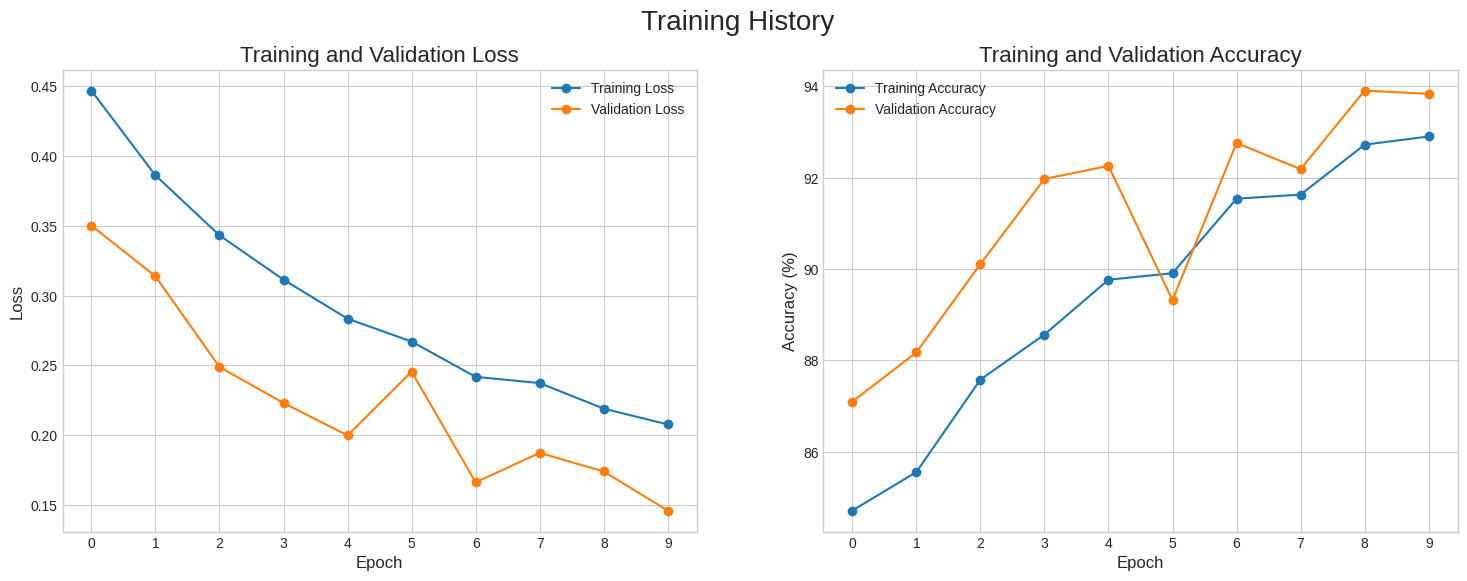

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ===================================================================
# 1. Grafik Training & Validation Loss dan Accuracy
# ===================================================================

def plot_training_history(logs):
    """Membuat plot untuk loss dan akurasi selama training."""
    
    epochs = range(logs['epoch'] + 1)
    
    train_loss = [logs.get(f'epoch_{e}_train_loss', None) for e in epochs]
    val_loss = [logs.get(f'epoch_{e}_valid_loss', None) for e in epochs]
    
    train_acc = [logs.get(f'epoch_{e}_train_acc', None) for e in epochs]
    val_acc = [logs.get(f'epoch_{e}_valid_acc', None) for e in epochs]

    # Membersihkan nilai None jika training dihentikan di tengah jalan
    epochs_loss = [e for e, tl, vl in zip(epochs, train_loss, val_loss) if tl is not None and vl is not None]
    train_loss = [tl for tl in train_loss if tl is not None]
    val_loss = [vl for vl in val_loss if vl is not None]
    
    epochs_acc = [e for e, ta, va in zip(epochs, train_acc, val_acc) if ta is not None and va is not None]
    train_acc = [ta for ta in train_acc if ta is not None]
    val_acc = [va for va in val_acc if va is not None]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Loss
    ax1.plot(epochs_loss, train_loss, 'o-', label='Training Loss')
    ax1.plot(epochs_loss, val_loss, 'o-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.set_xticks(epochs_loss)

    # Plot Accuracy
    ax2.plot(epochs_acc, train_acc, 'o-', label='Training Accuracy')
    ax2.plot(epochs_acc, val_acc, 'o-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.set_xticks(epochs_acc)
    
    fig.suptitle('Training History', fontsize=20)
    plt.show()

try:
    if 'logs' in locals() and logs:
        print("Membuat plot dari log training yang ada di memori...")
        plot_training_history(logs)
    else:
        raise NameError("Variabel 'logs' tidak ditemukan.")
# Jika gagal (misal, kernel di-restart), coba muat dari checkpoint
except (NameError, KeyError):
    print("Log dari memori tidak ditemukan. Mencoba memuat dari checkpoint terakhir...")
    
    # Pastikan variabel `config` ada
    if 'config' in locals():
        latest_ckpt_path = os.path.join(config.checkpoint_dir, 'ckpt_latest.pth')
        
        if os.path.exists(latest_ckpt_path):
            ckpt = torch.load(latest_ckpt_path, map_location='cpu') # Muat ke CPU agar tidak butuh GPU
            logs_from_ckpt = ckpt.get('logs')
            
            if logs_from_ckpt:
                print("Berhasil memuat log dari checkpoint. Membuat plot...")
                plot_training_history(logs_from_ckpt)
            else:
                print("Checkpoint ditemukan, tetapi tidak berisi 'logs'.")
        else:
            print(f"Checkpoint terakhir tidak ditemukan di: {latest_ckpt_path}")
    else:
        print("Variabel 'config' tidak ditemukan untuk mencari path checkpoint.")

2025-06-14 07:19:42,712 - INFO - MAT: Initializing backbone 'resnet101'...


Memuat model dari: /kaggle/working/checkpoints/ffpp_mat_resnet101_v1/ckpt_best.pth


2025-06-14 07:19:43,385 - INFO - Loading pretrained weights from Hugging Face hub (timm/resnet101.a1h_in1k)
2025-06-14 07:19:43,534 - INFO - [timm/resnet101.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-06-14 07:19:43,587 - INFO - Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
2025-06-14 07:19:43,608 - INFO - MAT: Dry running backbone to get feature shapes...
2025-06-14 07:19:43,758 - INFO -   > Feature layer 's2' channels: 256
2025-06-14 07:19:43,759 - INFO -   > Attention layer 's3' channels: 512
2025-06-14 07:19:43,759 - INFO -   > Global branch layer 'final_conv' channels: 1024
2025-06-14 07:19:43,775 - INFO - MAT: Using TextureEnhance v2
2025-06-14 07:19:43,941 - INFO - MAT: Using AuxiliaryLoss v1
2025-06-14 07:19:44,286 - INFO - Berhasil memuat 640 kunci. Hilang: 0. Tak terduga: 0
2025-06-14 07:19:44,915 - INFO - Dataset phas

Menjalankan evaluasi pada set validasi...
  Batch 50/88 selesai.
Evaluasi selesai.

Classification Report
              precision    recall  f1-score   support

        REAL       0.77      0.79      0.78       193
        FAKE       0.97      0.96      0.96      1202

    accuracy                           0.94      1395
   macro avg       0.87      0.88      0.87      1395
weighted avg       0.94      0.94      0.94      1395



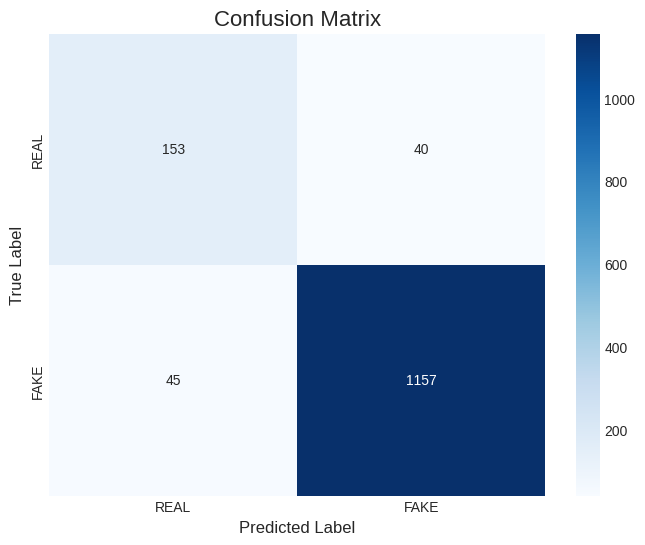

In [24]:
# ===================================================================
# 2. Confusion Matrix dan Laporan Klasifikasi
# ===================================================================

def evaluate_and_plot_confusion_matrix(config_obj: Config):
    """Mengevaluasi model pada set validasi dan membuat confusion matrix."""
    
    # --- Muat model terbaik ---
    best_model_path = os.path.join(config_obj.checkpoint_dir, 'ckpt_best.pth')
    if not os.path.exists(best_model_path):
        print(f"Model terbaik tidak ditemukan di {best_model_path}. Menggunakan model terakhir.")
        best_model_path = os.path.join(config_obj.checkpoint_dir, 'ckpt_latest.pth')
        if not os.path.exists(best_model_path):
            print("Tidak ada model yang bisa dimuat untuk evaluasi.")
            return

    print(f"Memuat model dari: {best_model_path}")
    net = MAT(**config_obj.net_config).to(DEVICE)
    ckpt = torch.load(best_model_path, map_location=DEVICE)
    load_state(net, ckpt['state_dict'])
    net.eval()
    
    # --- Siapkan DataLoader untuk validasi ---
    val_dataset = DeepfakeDataset('valid', config_obj.images_folder_path, config_obj.labels_csv_path, config_obj.net_config['size'], augment=False)
    val_loader = DataLoader(val_dataset, batch_size=config_obj.batch_size, shuffle=False, num_workers=config_obj.workers, pin_memory=True)
    
    all_preds = []
    all_labels = []
    
    print("Menjalankan evaluasi pada set validasi...")
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(val_loader):
            X_batch = X_batch.to(DEVICE)
            
            logits = net(X_batch)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            
            if (i+1) % 50 == 0:
                print(f"  Batch {i+1}/{len(val_loader)} selesai.")
    
    print("Evaluasi selesai.")

    # --- Tampilkan Classification Report ---
    class_names = ['REAL', 'FAKE'] # Sesuaikan jika label Anda berbeda
    print("\n" + "="*50)
    print("Classification Report")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

evaluate_and_plot_confusion_matrix(config)